In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
from methods.normal_map_integration import *
from methods.photos_to_stokes import *
import cv2
from scipy.ndimage import gaussian_filter
from matplotlib import cm
import mplcatppuccin
import matplotlib as mpl

mpl.style.use("frappe")

### Загрузка изображений

Загрузим изображения и вычислим распределение парметров Стокса на фотографии. Это поможет нам вычислить распределение степени и угла поляризации

In [15]:
def visualize_polarization_distribution(polarization: dict):
    fig, ax  = plt.subplots(1, 3, figsize = (18, 7), dpi = 300)
    ax[0].imshow(polarization['s0'], cmap = cm.Greys)
    ax[0].set_title("S0", fontsize = 16)
    dop = ax[1].imshow(polarization['linear_polarizatioin_degree'], cmap = cm.jet)
    ax[1].set_title("Степень поляризации")
    plt.colorbar(dop, ax = ax[1])
    aop = ax[2].imshow(polarization['angle_of_polarization'], cmap = cm.rainbow)
    plt.colorbar(aop, ax = ax[2])
    ax[2].set_title("Угол поляризации")
    fig.tight_layout()

In [16]:
polarization_0 = cv2.imread("data/chashka/000.png", cv2.IMREAD_GRAYSCALE)[420:550, 650:800]
polarization_45 = cv2.imread("data/chashka/045.png", cv2.IMREAD_GRAYSCALE)[420:550, 650:800]
polarization_90 = cv2.imread("data/chashka/090.png", cv2.IMREAD_GRAYSCALE)[420:550, 650:800]
polarization_135 = cv2.imread("data/chashka/135.png", cv2.IMREAD_GRAYSCALE)[420:550, 650:800]


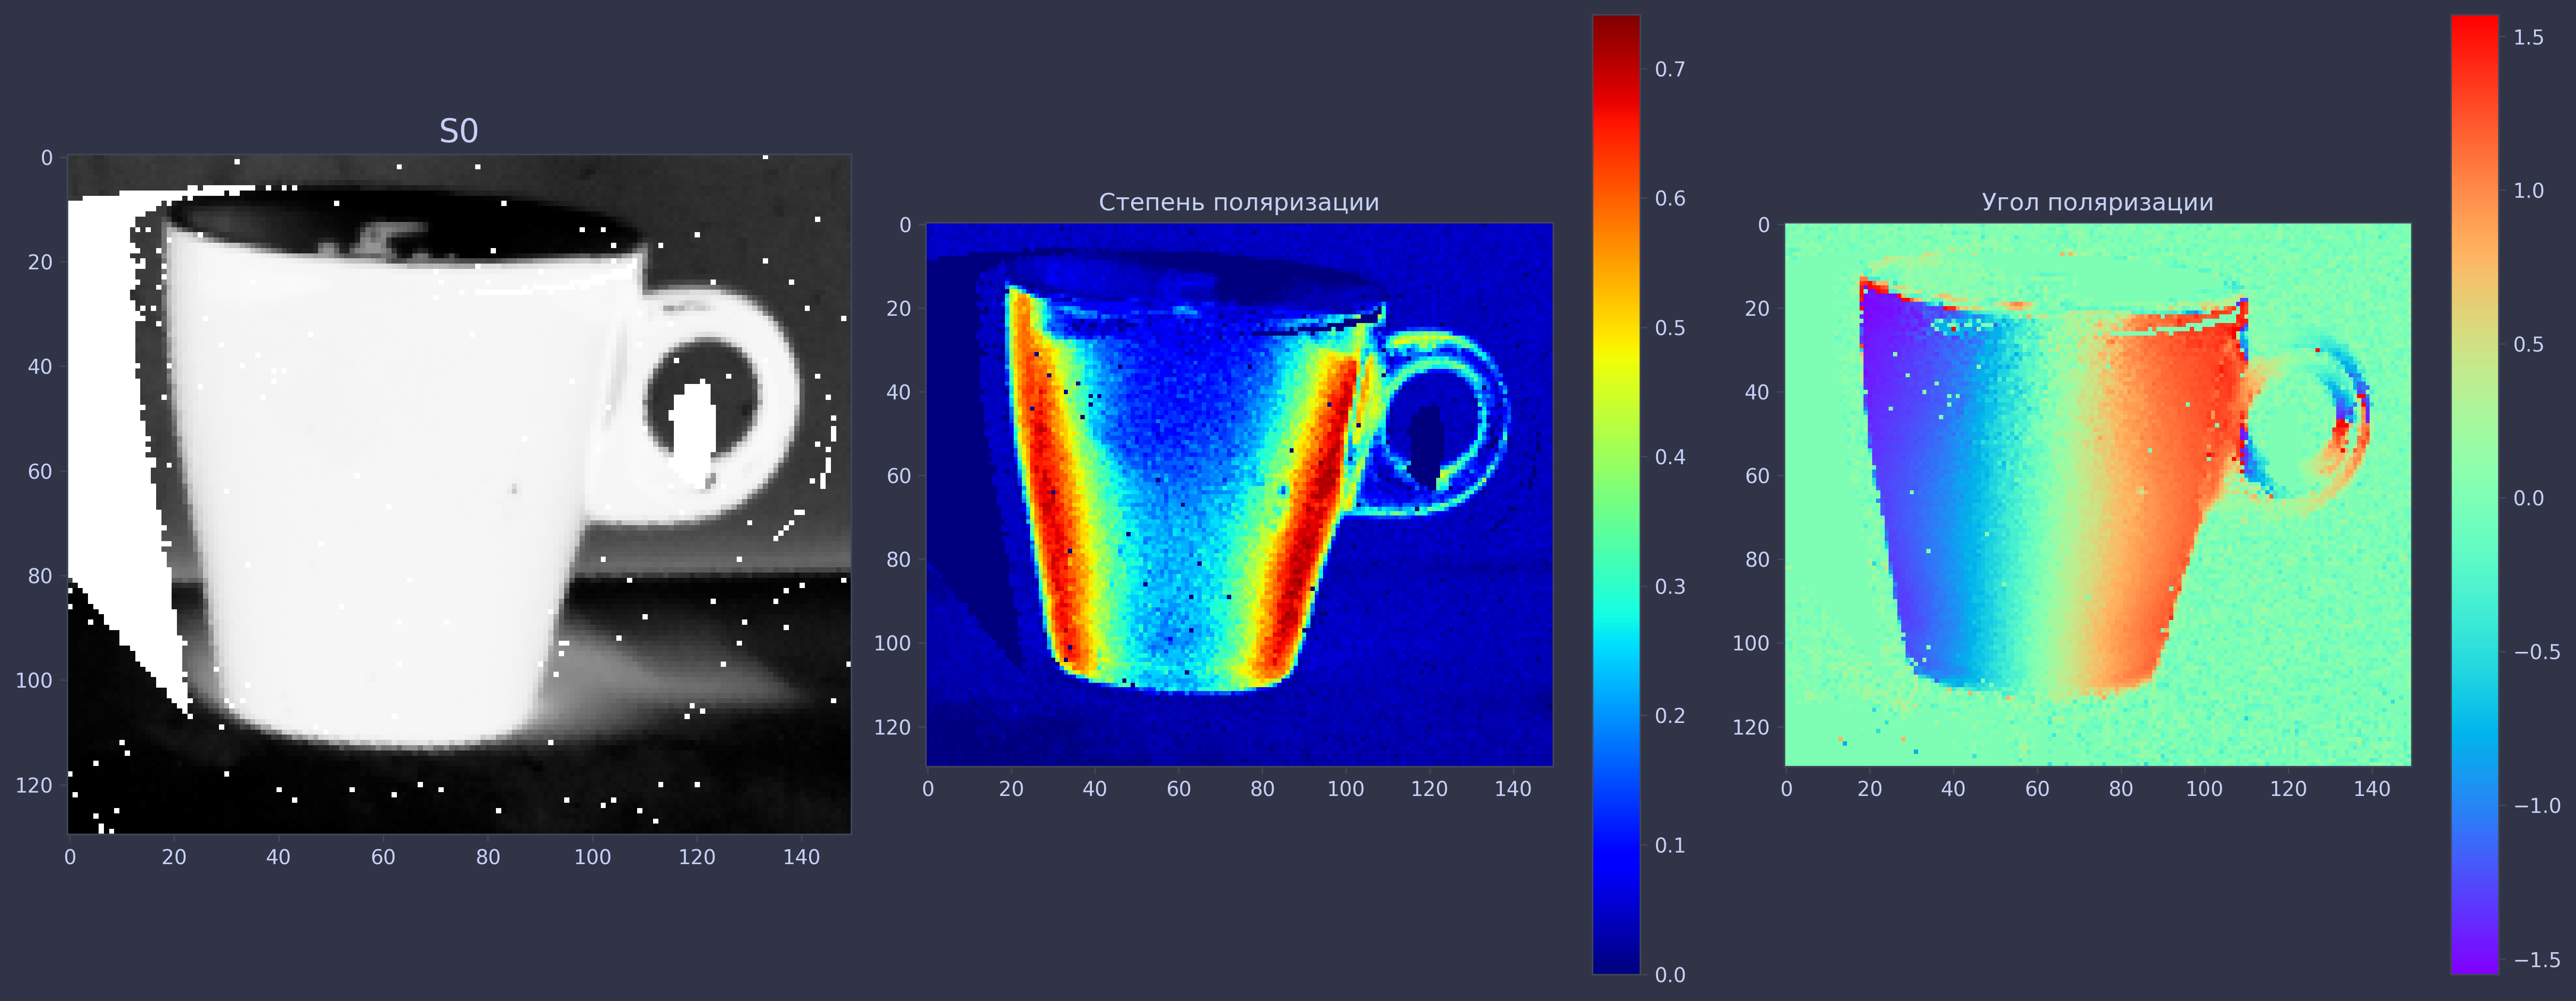

In [17]:
res = polarization(polarization_0 = polarization_0, 
                   polarization_135 = polarization_135,
                   polarization_45 = polarization_45,
                   polarization_90 = polarization_90)
visualize_polarization_distribution(res)

### Рассчёт карты нормалей

In [18]:
def deffuse_polarization_degree(theta: np.ndarray, n: float = 1.7) -> np.ndarray:
    """Зависимость степени поляризации от угла отражения

    Args:
        theta (np.ndarray): Угол отражения
        n (float, optional): Показатель преломления. Defaults to 1.7.

    Returns:
        np.ndarray: Степень поляризации
    """
    numerator = np.power(n - 1 / n, 2) * np.power(np.sin(theta), 2)
    denominator = 2 + 2 * np.power(n, 2) - np.power(n + 1 / n, 2) * np.power(np.sin(theta), 2) + 4 * np.cos(theta) * np.sqrt(np.power(n, 2) - np.power(np.sin(theta), 2))
    return numerator / denominator
def polarization_degree_to_reflection_angle(dolp: np.ndarray, n: float = 1.7) -> np.ndarray:
    """Функция, обратная к `diffuse_polarization_degree`. Рассчет угла отражения по степени поляризации.

    Args:
        dolp (np.ndarray): Степень поляризации
        n (float, optional): Показатель преломления. Defaults to 1.7.

    Returns:
        np.ndarray: Угол отражения
    """
    temp = np.sqrt((2 * dolp + 2 * n**2 * dolp - 2 * n**2 + n**4 + dolp**2 + 4 * n**2 * dolp**2 - n**4 * dolp**2 - 4 * n**3 * dolp * np.sqrt(-(dolp - 1) * (dolp + 1))) + 1) / np.sqrt(n**4 * dolp**2 + 2 * n**4 * dolp + n**4 + 6 * n**2 * dolp**2 + 4 * n**2 * dolp - 2 * n**2 + dolp**2 + 2 * dolp + 1)
    temp = np.minimum(np.real(temp), 1)
    theta_val = np.arccos(temp)
    return theta_val

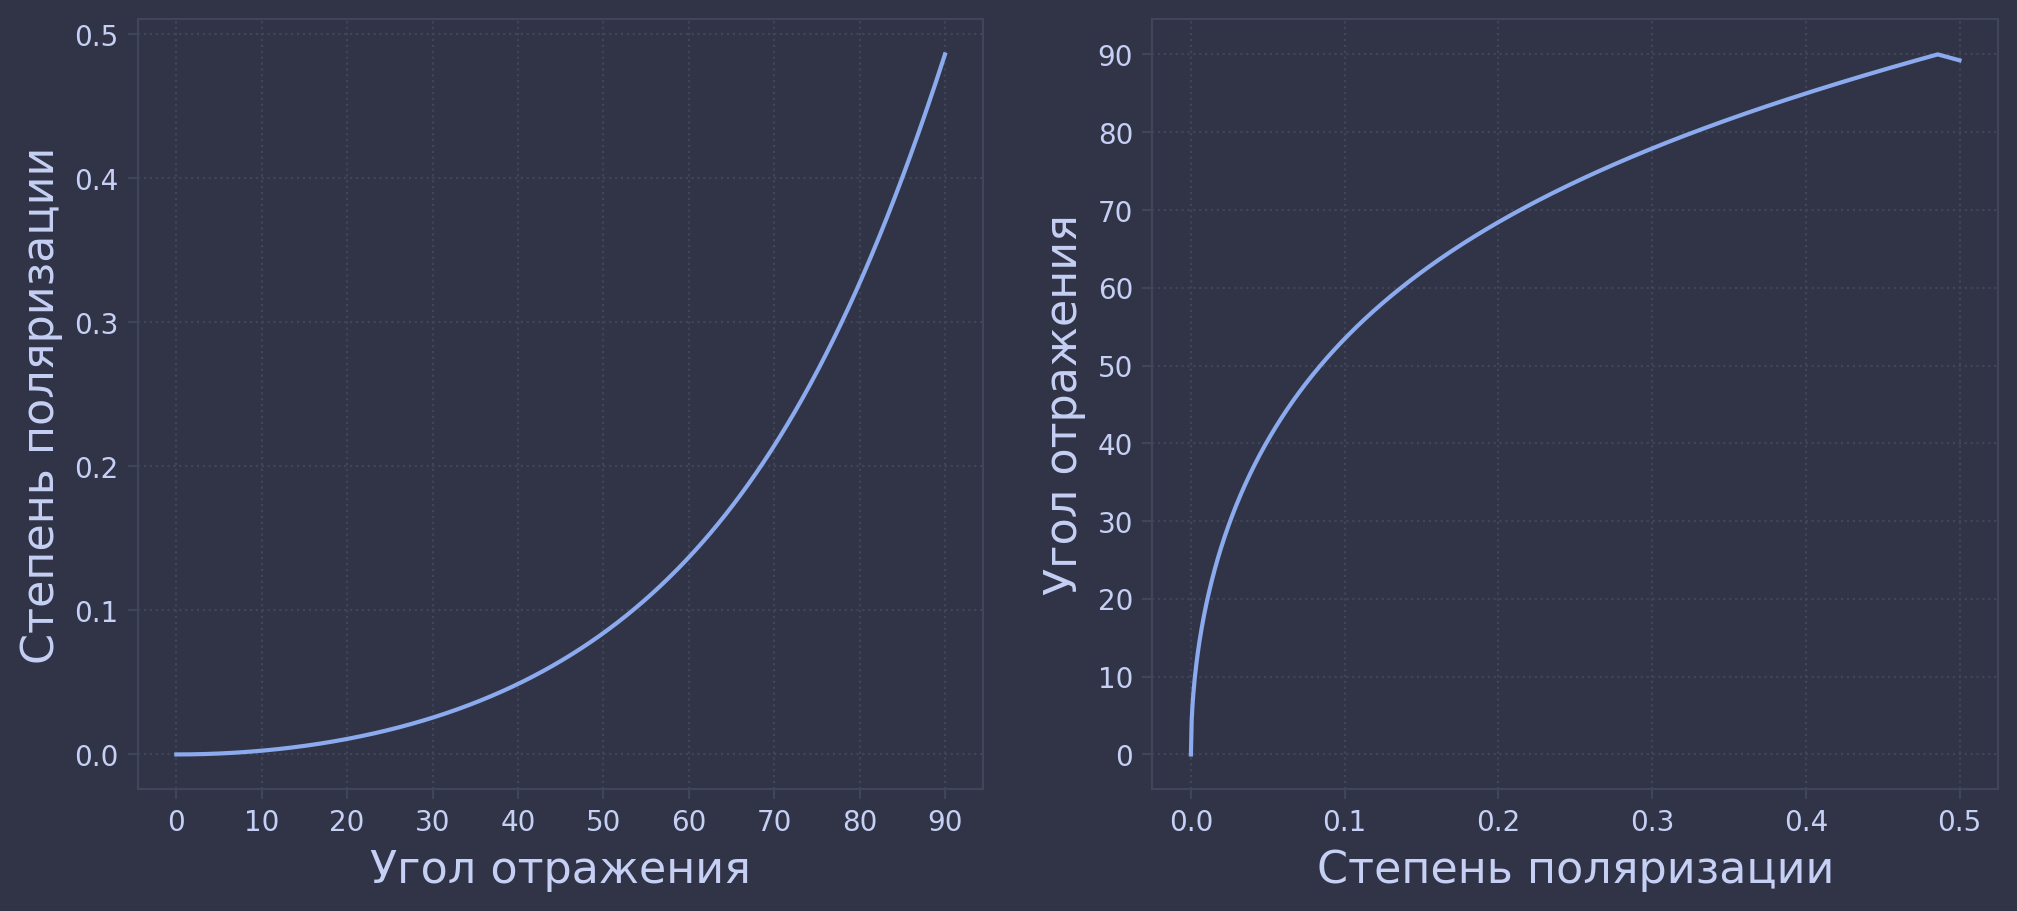

In [19]:
theta_val = np.linspace(0, np.pi / 2, 1000)
dolp = np.linspace(0, 0.5, 1000)

fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 200)
ax[0].plot(theta_val * 180 / np.pi, deffuse_polarization_degree(theta_val))
ax[0].grid(ls = ':')
ax[0].set_xticks(np.arange(0, 100, 10))
ax[0].set_xlabel("Угол отражения", fontsize = 16)
ax[0].set_ylabel("Степень поляризации", fontsize = 16)

ax[1].plot(dolp, polarization_degree_to_reflection_angle(dolp) * 180 / np.pi)
ax[1].set_yticks(np.arange(0, 100, 10))
ax[1].set_ylabel("Угол отражения", fontsize = 16)
ax[1].set_xlabel("Степень поляризации", fontsize = 16)
ax[1].grid(ls = ':')

Найдём распределение угла отражения на нашей фотографии. Согласно источнику [Википедия](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B7%D1%80%D0%B0%D1%87%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B5%D1%80%D0%B0%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%B0%D0%BB%D1%8B), коэффициент преломления керамики $n = 2.08$. Будем использовать это значение.

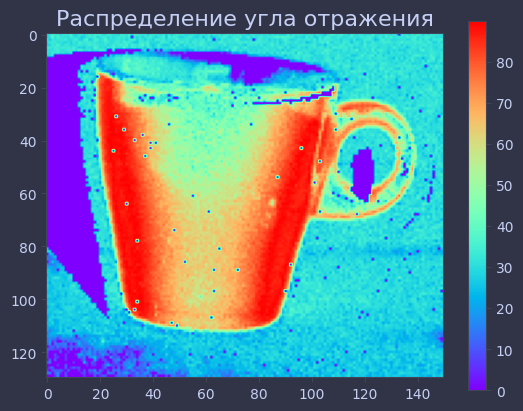

In [20]:
n_ceramics = 2.08
theta = polarization_degree_to_reflection_angle(res['linear_polarizatioin_degree'], n = n_ceramics)
im = plt.imshow(theta * 180 / np.pi, cmap = cm.rainbow)
plt.colorbar(im)
plt.title("Распределение угла отражения", fontsize = 16);

Найдём карту нормалей:
$$
\begin{pmatrix}
n_{x} \\
n_{y} \\
n_{z} 
\end{pmatrix} = 
\begin{pmatrix}
cos(\phi) sin(\theta) \\
sin(\phi) sin(\theta) \\
cos(\theta)
\end{pmatrix} \propto
\begin{pmatrix}
cos(\phi) tg(\theta) \\
sin(\phi) tg(\theta) \\
1
\end{pmatrix} 
$$

$\phi$ - угол поляризации, $\theta$ - угол отражения

/home/vladimir/.local/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/vladimir/.local/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


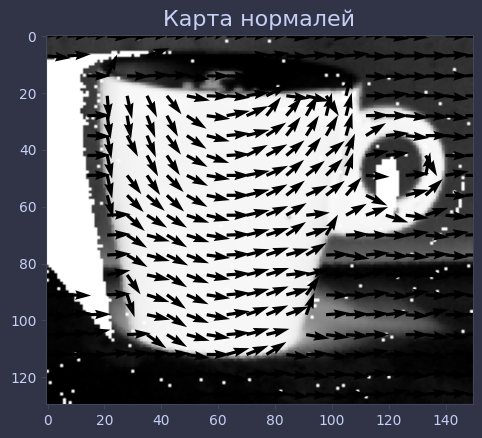

In [21]:

normal_map = np.array([np.tan(theta) * np.cos(res['angle_of_polarization']),
                       np.tan(theta * np.sin(res['angle_of_polarization'])),
                       np.ones_like(theta)]).T
normal_map = np.swapaxes(normal_map, 0, 1)
normal_map /= np.linalg.norm(normal_map, ord = 2, keepdims = True, axis = 2)
normal_map = (np.cos(theta) > 1e-2)[:, :, np.newaxis] * normal_map
low_dolp = res['linear_polarizatioin_degree'] < 1e-2
normal_map[low_dolp] = np.zeros(3) 
cv2.imwrite('normal_map.png', normal_map * 255)
cv2.imwrite('mask.png', np.ones_like(normal_map) * 255)

plt.imshow(res['s0'], cmap = cm.Greys)
for x in range(0, normal_map.shape[0], 7):
    for y in range(0, normal_map.shape[1], 7):
        plt.quiver(y, x, normal_map[x, y, 0], normal_map[x, y, 1])
plt.title("Карта нормалей", fontsize = 16);

### Восстановление карты высот по найденной карте нормалей

Будем использовать алгоритм, реализованный в файле `methods/normal_map_integration.py`. 

Пусть карта нормалей задана двумя функциями - $p(x, y), q(x, y)$:

$$
\vec{n}(x, y) = (p(x, y), q(x, y), 1)^{T}
$$

Как известно из матматического анализа, нормаль к явно заданной поверхности $z = f(x, y)$ есть
$$
(-\frac{\partial f}{\partial x}, -\frac{\partial f}{\partial y}, 1)^{T}
$$

Таким образом, логично искать карту высот(функцию $f$), которая минимизирует ошибку:
$$
E = \iint\limits_{изображение} \left(\frac{\partial f}{\partial x}(x, y) + p(x, y) \right)^{2} + \left(\frac{\partial f}{\partial y}(x, y) + q(x, y) \right)^{2} d x d y
$$

Оказывается, что Фурье-образ наилучшей функции $f$(для которой $E$ минимальна) связан с Фурье образами функций $p$ и $q$:
$$
\hat{F} = \frac{i u P(u, v) + i v Q(u, v)}{(u + v)^{2}}
$$


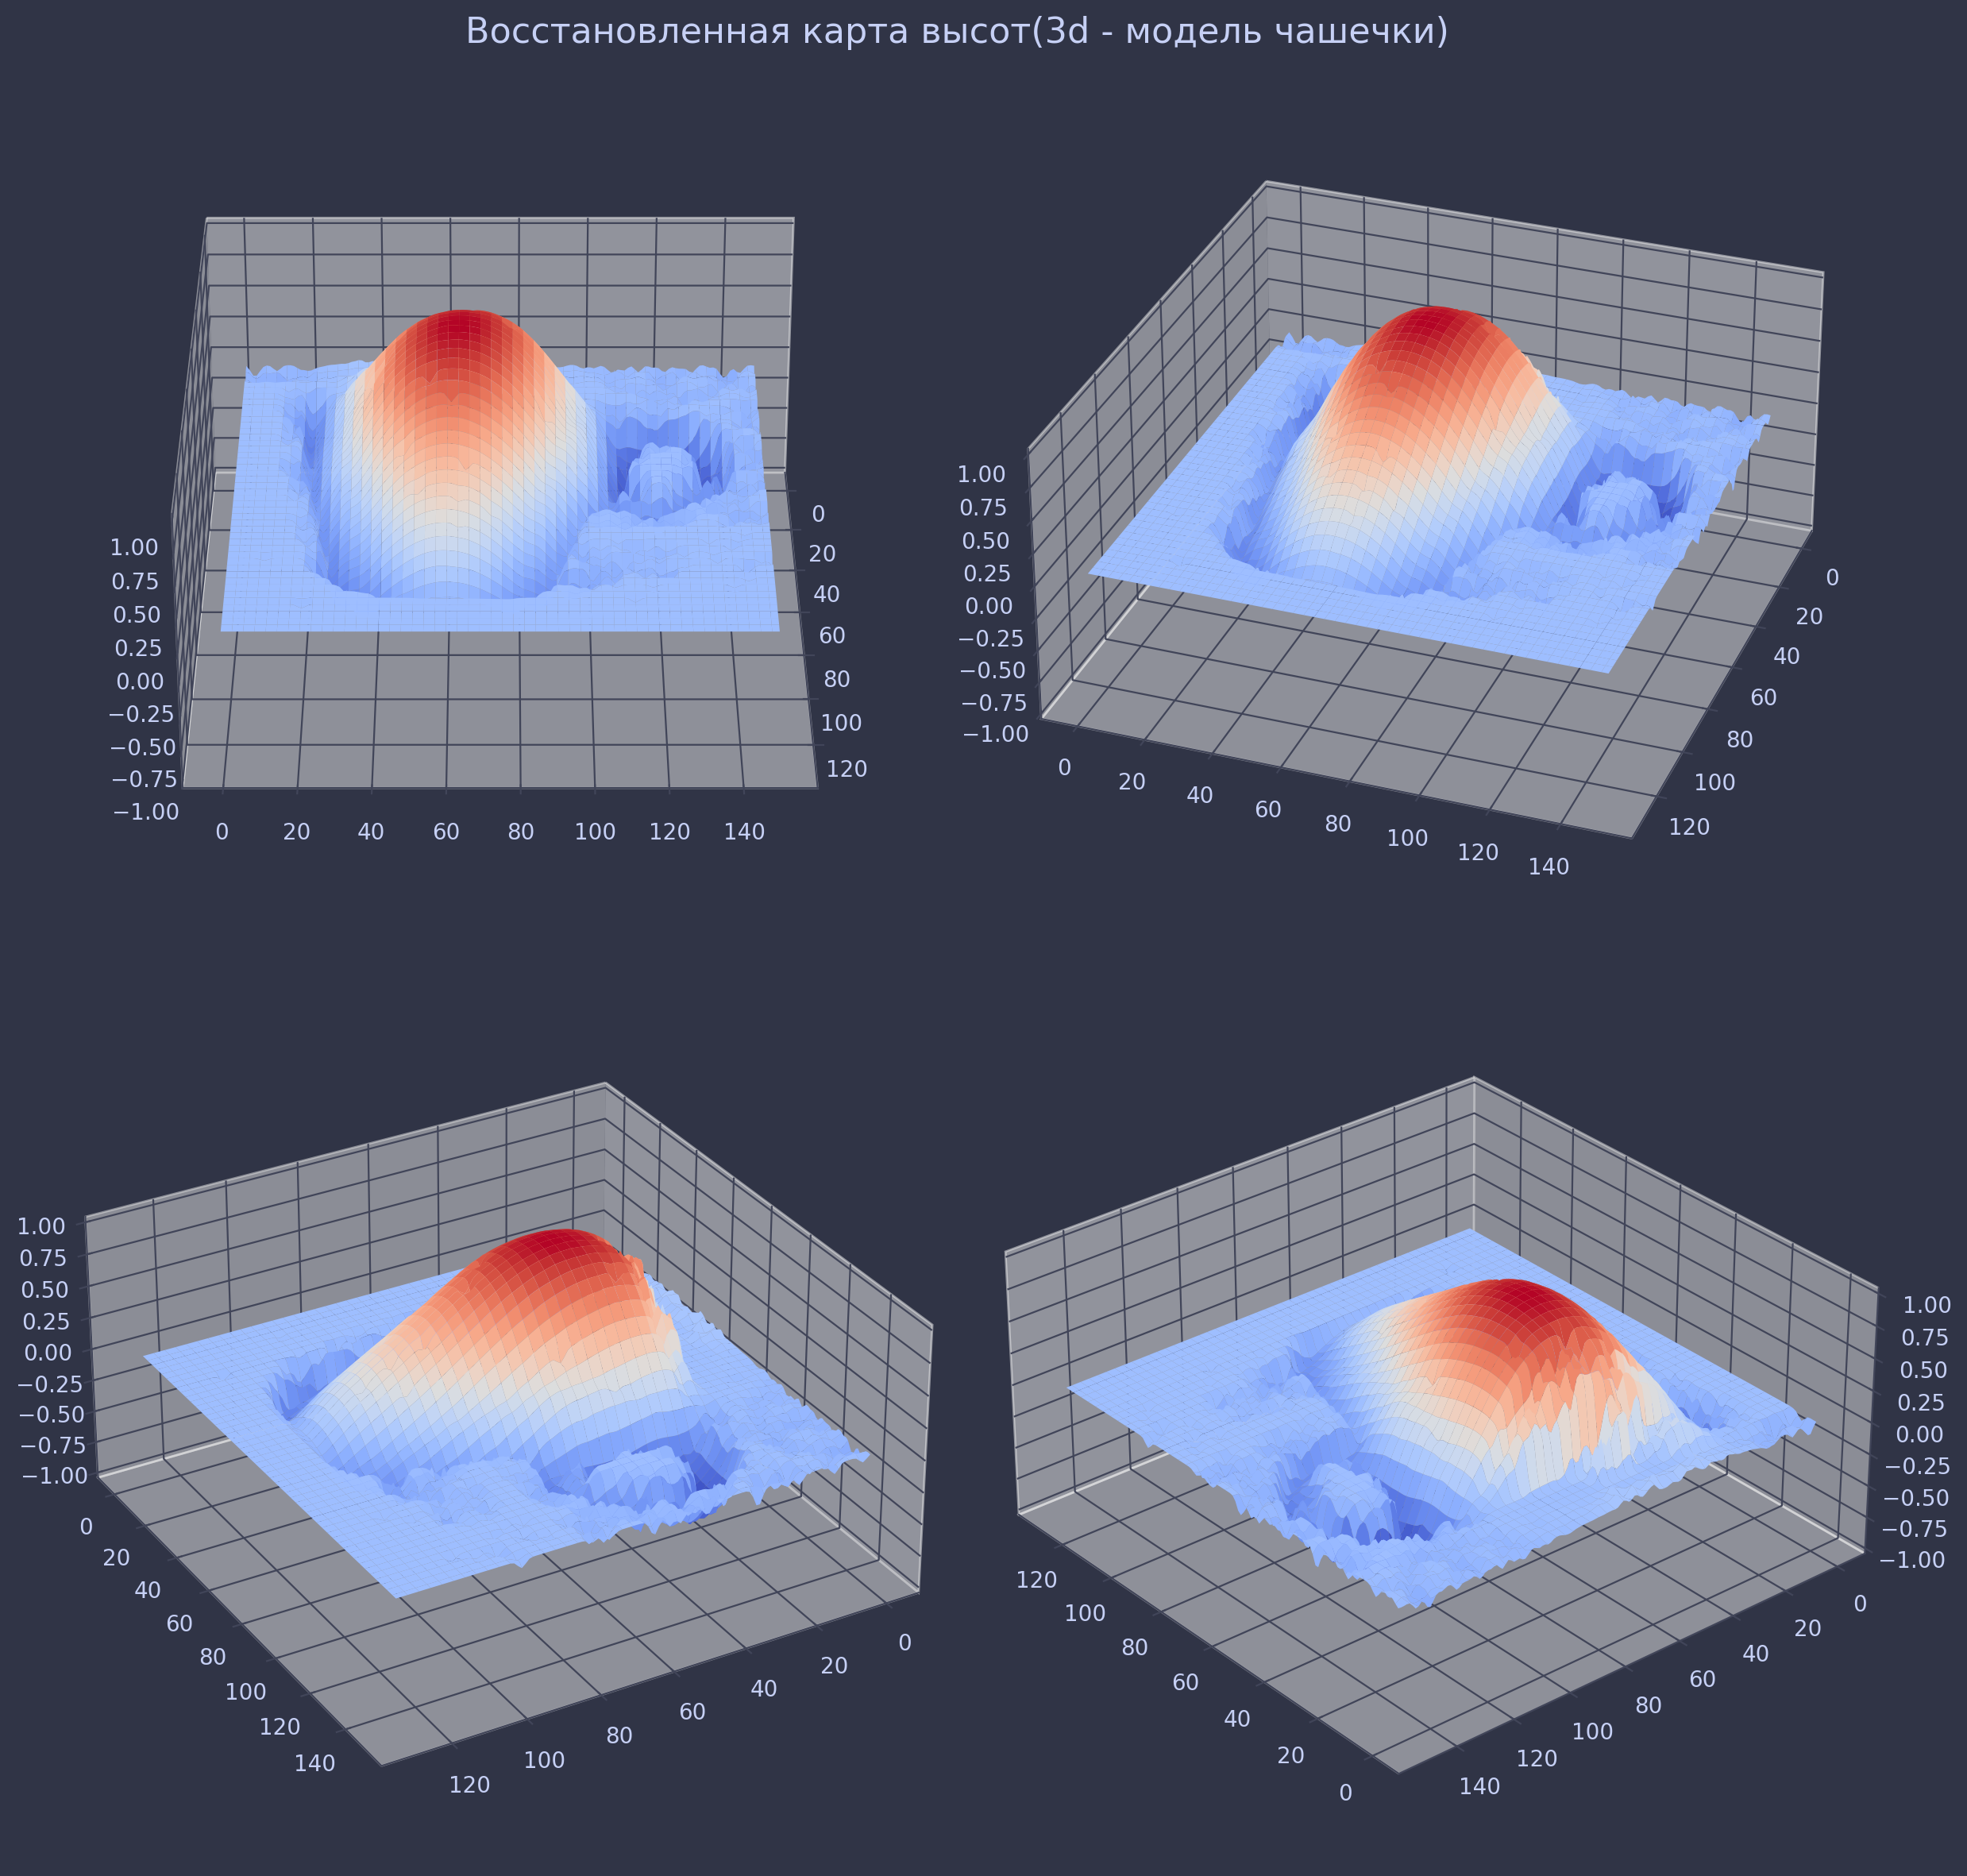

In [22]:
depth_map = normal_map_least_square_integration(normal_map)
depth_map /= np.max(np.abs(depth_map))
mask = res['linear_polarizatioin_degree'] < 1e-2 * 5 
x, y = np.arange(depth_map.shape[0]), np.arange(depth_map.shape[1])
X, Y = np.meshgrid(x, y)
Z = np.copy(depth_map)
Z[mask] = 0
Z = gaussian_filter(Z, sigma = 1)
fig = plt.figure(figsize = (12, 12), dpi = 200)
angles = [0, 20, 60, 140]
for i, a in enumerate(angles): 
    ax = fig.add_axes(int(f'22{i + 1}'), projection = '3d')
    ax.plot_surface(X, Y, Z.T, antialiased = True, cmap = cm.coolwarm)
    ax.view_init(30, a, 0)
    ax.set_box_aspect([1, 1, 0.5])
    ax.set_zlim(-1, 1)

fig.suptitle("Восстановленная карта высот(3d - модель чашечки)", fontsize = 16)
fig.tight_layout()

(130, 150)


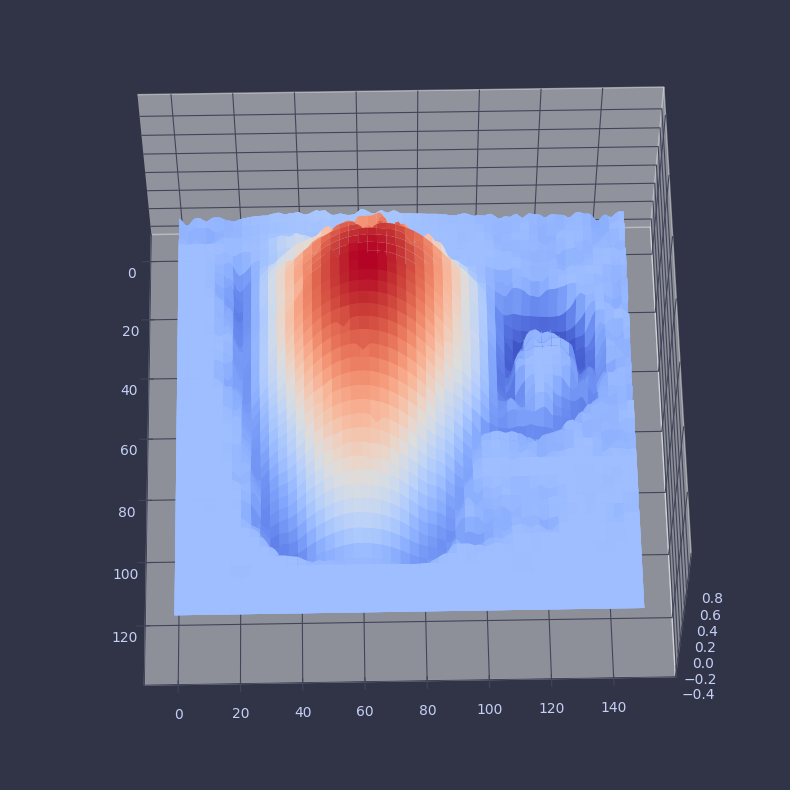

In [23]:
from matplotlib import animation
fig = plt.figure(figsize = (10, 10))
ax = fig.add_axes(111, projection = '3d')
print(depth_map.shape)

def init():
    ax.plot_surface(X, Y, Z.T, antialiased = True, cmap = cm.coolwarm)
    ax.view_init(40, 60, 0)
    ax.set_box_aspect([1,1,0.5])
    return fig,

def animate(i):
    ax.view_init(elev=60., azim=i)
    return fig,

# Animate
init() 
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('rotation_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])